In [1]:
import gurobi as gb
from gurobipy import GRB

import networkx as nx
import numpy as np
import math

# Network model

In [2]:
from functions_library import *

# Gurobi Optimization
Implementation of the LP, which Arash proposed on 6. June 2022

In [3]:
opt_mod = gb.Model(name="linear programm")

Set parameter Username
Academic license - for non-commercial use only - expires 2023-06-02


## Setup Network Parameters

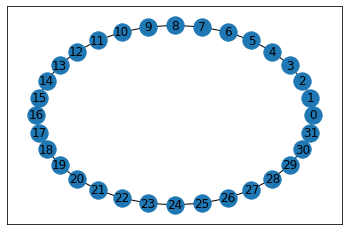

In [4]:
k = 5
G = init_ring(2**k)
D = init_uniformDemand_matrix(G)
#adjM = np.full((2**k,2**k),0)
#A = nx.adjacency_matrix(G)

## Setting variables

In [5]:
n = len(G.nodes)

nodesPairList = gb.tuplelist(complete_node_pair_list(G))
allShortestPath = nx.shortest_path(G)

# Edges/Links gb.var definition and constraints
"""e = []
for i in G.nodes:
    e.append([])
    for j in G.nodes:
        e[i].append(opt_mod.addVar(name=f"e_{i,j}", vtype=GRB.BINARY))
opt_mod.update() """

"""#distance, x, y, flow
dist = []
x = []
for i in G.nodes:
    dist.append([])
    x.append([])
    for j in G.nodes:
        dist[i].append(opt_mod.addVar(name=f"dist_{i,j}", vtype="I", lb=0, ub=GRB.INFINITY))
        x[i].append([])
        for u in G.nodes:
            x[i][j].append([])
            for v in G.nodes:
                x[i][j][u].append(opt_mod.addVar(name=f"x_{i,j}_{u,v}", vtype="B"))  
x = np.array(x)
opt_mod.update() """

#Optimized Gurobi arrays
e = opt_mod.addVars(G.nodes, G.nodes, name="e", vtype="B")
opt_mod.update() 
dist = opt_mod.addVars(G.nodes, G.nodes, name="dist", vtype="I", lb=0, ub=GRB.INFINITY)
opt_mod.update() 
x = opt_mod.addVars(G.nodes, G.nodes, G.nodes, G.nodes, name="x", vtype="B")
opt_mod.update() 

## Adding constraints

In [6]:
# Adjacency Matrix (e) Constraints
opt_mod.addConstrs((e[i,(i+1) % len(G.nodes)] == 1 for i in G.nodes), name="c-ring")
opt_mod.addConstrs((e[i,i] == 0 for i in G.nodes), name="c-noSelfEdge")
opt_mod.addConstrs((e.sum(i,'*') <= math.log(2**k,2) + 2 for i in G.nodes), name="c-logE")
opt_mod.addConstrs((e[i,j] == e[j,i] for i in G.nodes for j in G.nodes), name="c-undirected")
        
        
# Distance Matrix (dist) Constraints. dist[i][j]:= SP-length between i and j
for i in G.nodes:
    #opt_mod.addConstr(dist[i,i] == 0, name="c-dist-self")
    #opt_mod.addConstr(dist[i][(i+1) % len(G.nodes)] == 1, name="c-dist-ring")
    for j in G.nodes:
        opt_mod.addConstr(dist[i,j] == (x.sum(i,j,'*','*')/2), name="c-subpath0")
        #opt_mod.addConstr(dist[i,j] >= e[i,j], name="c-dist1")
        for u in G.nodes:
            opt_mod.addConstr(dist[i,j] <= dist[i,u] + dist[u,j] , name="c-dist2")



# Ensuring that x shows a correct path
for i in G.nodes:
    for j in G.nodes:
        opt_mod.addConstr(x[i,j,i,i] == 0, name="c-noSelfE")
        if i != j:
            opt_mod.addConstr(x.sum(i,j,i,'*') == 1, name="c-flowStart")
            opt_mod.addConstr(x.sum(i,j,'*',j) == 1, name="c-flowEnd")
            for v in G.nodes:
                if v != j:
                    opt_mod.addConstr((x.sum(i,j,'*',v) - x.sum(i,j,v,'*')) == 0, name="blue0")
                for u in G.nodes:   
                    opt_mod.addConstr(x[i,j,u,v] <= e[u,v], name="flow0")

In [7]:
#opt_mod.addConstr(sum(x[i][j][i]) == 1, name="flow0")
#opt_mod.addConstr(sum(x[i][j][i]) == 1, name="flow0")

## Objective

In [ ]:
#print(len(x[0,1,x,y]))
nodesPairListNoDuplication = complete_node_pair_list_noDuplication(G)
opt_mod.setObjective(sum([dist[i,j]*D[i][j] for (i,j) in nodesPairListNoDuplication]), GRB.MINIMIZE)
opt_mod.update()


# Run
#opt_mod.display()
opt_mod.optimize()

Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (linux64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 1084480 rows, 1050624 columns and 5149696 nonzeros
Model fingerprint: 0xfdd170aa
Variable types: 0 continuous, 1050624 integer (1049600 binary)
Coefficient statistics:
  Matrix range     [5e-01, 1e+00]
  Objective range  [1e-03, 1e-03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 7e+00]
Presolve removed 99360 rows and 65104 columns (presolve time = 5s) ...
Presolve removed 100384 rows and 65168 columns (presolve time = 10s) ...


In [ ]:
"""if opt_mod.status == GRB.Status.OPTIMAL:
    print('Obj Function:', opt_mod.objVal)
    for v in opt_mod.getVars():
        print(v.varName, v.x)       
else:
    print(opt_mod.status)"""

# Putting it back into a graph

In [ ]:
G_sol = nx.Graph()
for i in range(n): 
    G_sol.add_node(i)

for i in G_sol.nodes:
    for j in range(i,len(G_sol.nodes)):
        if e[i,j].X == 1.0:
            G_sol.add_edge(i,j)


In [ ]:
pos = nx.circular_layout(G_sol)
nx.draw_networkx(G_sol,pos=pos,with_labels=True)

In [ ]:
print(calc_cost(G_sol,D))
print(dist)